In [1]:
import pandas as pd
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from statannot import add_stat_annotation
from gensim import corpora
import seaborn as sns
import matplotlib.pylab as plt
from scipy import spatial

In [2]:
def weights_df(model, df, corpus):
    topics = model.get_document_topics(bow = corpus, minimum_probability = 0)
    
    new_df = pd.DataFrame(df['Sample'])
    new_df['Chr'] = df['Chr']
    new_df['Chr'] = pd.to_numeric(new_df['Chr'])
    
    columns = [[],[],[],[],[]]
    for topic in topics:
        for w in topic:
            columns[w[0]].append(w[1])
    
    new_df['1'] = columns[0]
    new_df['2'] = columns[1]
    new_df['3'] = columns[2]
    new_df['4'] = columns[3]
    new_df['5'] = columns[4]
    new_df = new_df.sort_values(by='Chr').reset_index(drop=True)
    return new_df

In [3]:
file = pd.read_table('/home/janneae/cns/steps/featurefiles/discretized_10_0.7_5.features', dtype=str)
raw = pd.read_table('/home/janneae/cns/data/filteredAscatRaw.txt')
ascat = pd.read_table('/home/janneae/cns/data/filteredAscatRaw.txt', dtype=str)
file_30 = pd.read_table('/home/janneae/cns/steps/featurefiles/discretized_10_0.3_5.features')

In [4]:
lda = LdaModel.load('../steps/gensim/lda/lda_t5_f10_b5.model')
df = file.drop(['Sample', 'Chr', 'GCcSeg'], axis = 1)
listedDf = df.values.tolist()
dirichlet_dict = corpora.Dictionary(listedDf)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in listedDf]

In [5]:
weights_df = weights_df(lda, file, bow_corpus)

In [6]:
sampled_30 = file_30.drop(['Sample', 'Chr', 'GCcSeg'], axis = 1)
listed30 = sampled_30.values.tolist()
dirichlet_dict30 = corpora.Dictionary(listed30)
corpus30 = [dirichlet_dict30.doc2bow(text) for text in listed30]

## Validation of model on remaining 30%file

In [7]:
test_model = lda.get_document_topics(corpus30)

In [8]:
testmodel_df = pd.DataFrame(file_30['Sample'])
testmodel_df['Chr'] = file_30['Chr']
testmodel_df['Chr'] = pd.to_numeric(testmodel_df['Chr'])

columns = [[],[],[],[],[]]
for topic in test_model:
    for w in topic:
        columns[w[0]].append(w[1])

testmodel_df['1'] = columns[0]
testmodel_df['2'] = columns[1]
testmodel_df['3'] = columns[2]
testmodel_df['4'] = columns[3]
testmodel_df['5'] = columns[4]
testmodel_df = testmodel_df.sort_values(by='Chr').reset_index(drop=True)
weights_30 = testmodel_df

In [9]:
weights_30

,Sample,Chr,1,2,3,4,5
0,TCGA-02-0014,1,0.602040,0.023816,0.017838,0.344351,0.011954
1,TCGA-AA-3821,1,0.035970,0.024535,0.017841,0.014314,0.907340
2,TCGA-FV-A3R2,1,0.038451,0.501796,0.017852,0.429948,0.011954
3,TCGA-AA-3819,1,0.152197,0.024256,0.017851,0.793742,0.011954
4,TCGA-FV-A495-a,1,0.688066,0.023868,0.017814,0.014293,0.255959
...,...,...,...,...,...,...,...
72133,TCGA-AA-3560,22,0.406363,0.282338,0.017842,0.014275,0.279182
72134,TCGA-FY-A3TY-a,22,0.049833,0.405155,0.017788,0.515275,0.011949
72135,TCGA-WE-A8ZO,22,0.321428,0.458744,0.017820,0.014283,0.187725
72136,TCGA-AA-3527-a,22,0.581926,0.025963,0.017735,0.014253,0.360122


In [10]:
weights_df

,Sample,Chr,1,2,3,4,5
0,TCGA-02-0001,1,0.602017,0.023816,0.017838,0.344375,0.011954
1,TCGA-76-6280,1,0.036730,0.023488,0.273862,0.014269,0.651651
2,TCGA-J8-A3YD,1,0.932778,0.023399,0.017610,0.014274,0.011938
3,TCGA-J8-A3O1,1,0.035499,0.024063,0.432250,0.014252,0.493936
4,TCGA-76-6282,1,0.036087,0.023506,0.017724,0.014267,0.908416
...,...,...,...,...,...,...,...
168405,TCGA-G2-A2EJ,22,0.036800,0.024316,0.017788,0.909138,0.011958
168406,TCGA-AA-3521-a,22,0.036345,0.171695,0.765769,0.014241,0.011950
168407,TCGA-G2-A2EF,22,0.037784,0.317941,0.618054,0.014270,0.011951
168408,TCGA-AA-3519-a,22,0.038639,0.595291,0.339847,0.014276,0.011947


In [11]:
concat = pd.concat([weights_df.assign(dataset='70_percent'), weights_30.assign(dataset='30_percent')], ignore_index = True)
concat = pd.merge(left = concat, right = ascat[['cancer_type']], left_on = 'Sample', right_on = ascat['ID']).drop_duplicates().reset_index(drop=True)
concat = concat.drop(['Chr', 'Sample'], axis=1)
concat = pd.melt(concat, id_vars=['dataset', 'cancer_type'], var_name='Signature', value_name='Weight')
concat

,dataset,cancer_type,Signature,Weight
0,70_percent,GBM,1,0.602017
1,70_percent,GBM,1,0.035452
2,70_percent,GBM,1,0.036358
3,70_percent,GBM,1,0.544230
4,70_percent,GBM,1,0.036039
...,...,...,...,...
1202735,70_percent,PCPG,5,0.011939
1202736,70_percent,PCPG,5,0.011939
1202737,70_percent,PCPG,5,0.011939
1202738,70_percent,PCPG,5,0.011953


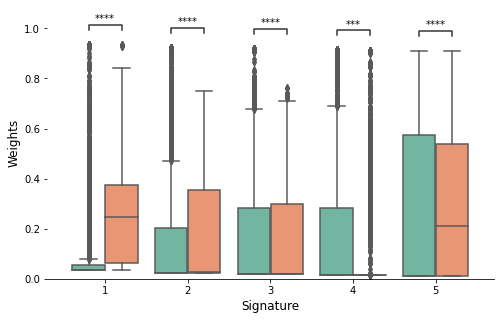

In [21]:
fig = plt.figure(figsize=(8, 5))

ax = sns.boxplot(x = 'Signature', y = 'Weight', data=concat, hue='dataset', palette='Set2')
ax.tick_params(axis="both", which="major", labelsize=8)
# ax.set_title(f"Training vs. Test Data", fontsize=18)
ax.set_ylabel("Weights", fontsize=12)
ax.set_xlabel("Signature", fontsize=12)
ax.set_ylim(0, 1)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
add_stat_annotation(ax, x = 'Signature', y = 'Weight', data=concat, hue='dataset',
                    box_pairs=[(("1", '70_percent'), ("1", '30_percent')), 
                               (("2", '70_percent'), ("2", '30_percent')),
                               (("3", '70_percent'), ("3", '30_percent')),
                               (("4", '70_percent'), ("4", '30_percent')),
                               (("5", '70_percent'), ("5", '30_percent'))
                                ],
                            test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
ax.get_legend().remove()
for i in "top right left".split():
    ax.spines[i].set_visible(False)
plt.savefig("../figures/figure9.pdf")

In [14]:
cosine30_df = pd.merge(left = weights_30, right = ascat[['cancer_type']], left_on = 'Sample', right_on = ascat['ID']).drop_duplicates().reset_index(drop=True)
cosine70_df = pd.merge(left = weights_df, right = ascat[['cancer_type']], left_on = 'Sample', right_on = ascat['ID']).drop_duplicates().reset_index(drop=True)

In [15]:
cancertypes = list(ascat['cancer_type'].unique())

In [16]:
onecancer_70 = cosine70_df[cosine70_df['cancer_type'] == cancertypes[0]]
onecancer_30 = cosine30_df[cosine30_df['cancer_type'] == cancertypes[0]]

concat = pd.concat([onecancer_70.assign(dataset='70_percent'), onecancer_30.assign(dataset='30_percent')], ignore_index = True)
concat = concat.drop(['Chr', 'Sample', 'cancer_type'], axis=1)
concat = pd.melt(concat, id_vars=['dataset'], var_name='Signature', value_name='Weight')
concat

,dataset,Signature,Weight
0,70_percent,1,0.602017
1,70_percent,1,0.035452
2,70_percent,1,0.036358
3,70_percent,1,0.544230
4,70_percent,1,0.036039
...,...,...,...
58075,30_percent,5,0.011956
58076,30_percent,5,0.011949
58077,30_percent,5,0.451837
58078,30_percent,5,0.656312


In [ ]:
fig, axes = plt.subplots(11, 3, figsize=(15,35))

counter = 0
for col in range(0, 3):
    for row in range(0, 11):
        onecancer_70 = cosine70_df[cosine70_df['cancer_type'] == cancertypes[counter]]
        onecancer_30 = cosine30_df[cosine30_df['cancer_type'] == cancertypes[counter]]
        
        concat = pd.concat([onecancer_70.assign(dataset='70_percent'), onecancer_30.assign(dataset='30_percent')], ignore_index = True)
        concat = concat.drop(['Chr', 'Sample', 'cancer_type'], axis=1)
        concat = pd.melt(concat, id_vars=['dataset'], var_name='Signature', value_name='Weight')
        
        if counter < 32:
            counter += 1

        sns.boxplot(ax=axes[row, col], x = 'Signature', y = 'Weight', data=concat, hue='dataset', palette='Set2')
        axes[row, col].set_ylabel("Weights", fontsize=10)
        # axes[row, col].set_xlabel("Signature", fontsize=10)
        axes[row, col].tick_params(axis='x', labelsize=7)
        axes[row, col].tick_params(axis='y', labelsize=7)
        axes[row, col].set_title(str(cancertypes[counter]), fontsize=10)
        add_stat_annotation(axes[row, col], x = 'Signature', y = 'Weight', data=concat, hue='dataset',
                    box_pairs=[(("1", '70_percent'), ("1", '30_percent')), 
                               (("2", '70_percent'), ("2", '30_percent')),
                               (("3", '70_percent'), ("3", '30_percent')),
                               (("4", '70_percent'), ("4", '30_percent')),
                               (("5", '70_percent'), ("5", '30_percent'))
                                ],
                            test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
        axes[row, col].get_legend().remove()
        
        for i in "top right left".split():
            axes[row, col].spines[i].set_visible(False)
plt.savefig("../figures/figure9.pdf")

### Cosine similarity

In [17]:
cosine_sim = []
for signature in range(1, 6):
    sig30_df = cosine30_df[str(signature)]
    sig70_df = cosine70_df[str(signature)]
    differences = []
    for i in range(1000):
        sample30 = sig30_df.sample(n = 10000, replace=True)
        sample70 = sig70_df.sample(n = 10000, replace=True)
        dist = 1 - spatial.distance.cosine(sample30, sample70)
        differences.append(dist)
    cosine_sim.append(differences)

In [18]:
cosine_df = pd.DataFrame(cosine_sim).transpose()
cosine_df = pd.melt(cosine_df, var_name = 'Signature', value_name = 'Cosine Similarity')
cosine_df.Signature = cosine_df.Signature + 1
cosine_df

,Signature,Cosine Similarity
0,1,0.428575
1,1,0.445133
2,1,0.446892
3,1,0.444401
4,1,0.446596
...,...,...
4995,5,0.399477
4996,5,0.392535
4997,5,0.383776
4998,5,0.383083


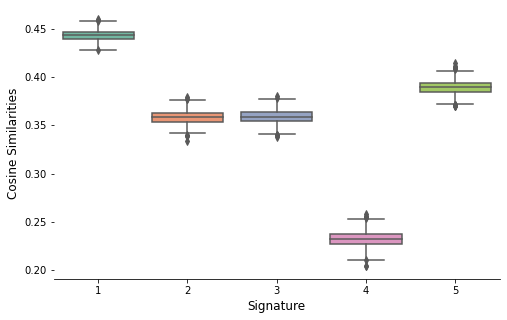

In [20]:
fig = plt.figure(figsize=(8, 5))

ax = sns.boxplot(x = 'Signature', y = 'Cosine Similarity', data=cosine_df, palette='Set2')
ax.tick_params(axis="both", which="major", labelsize=8)
# ax.set_title(f"Training vs. Test Data", fontsize=18)
ax.set_ylabel("Cosine Similarities", fontsize=12)
ax.set_xlabel("Signature", fontsize=12)
# ax.set_ylim(0, 1)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
for i in "top right left".split():
    ax.spines[i].set_visible(False)
plt.savefig("../figures/figure9cosine.pdf")

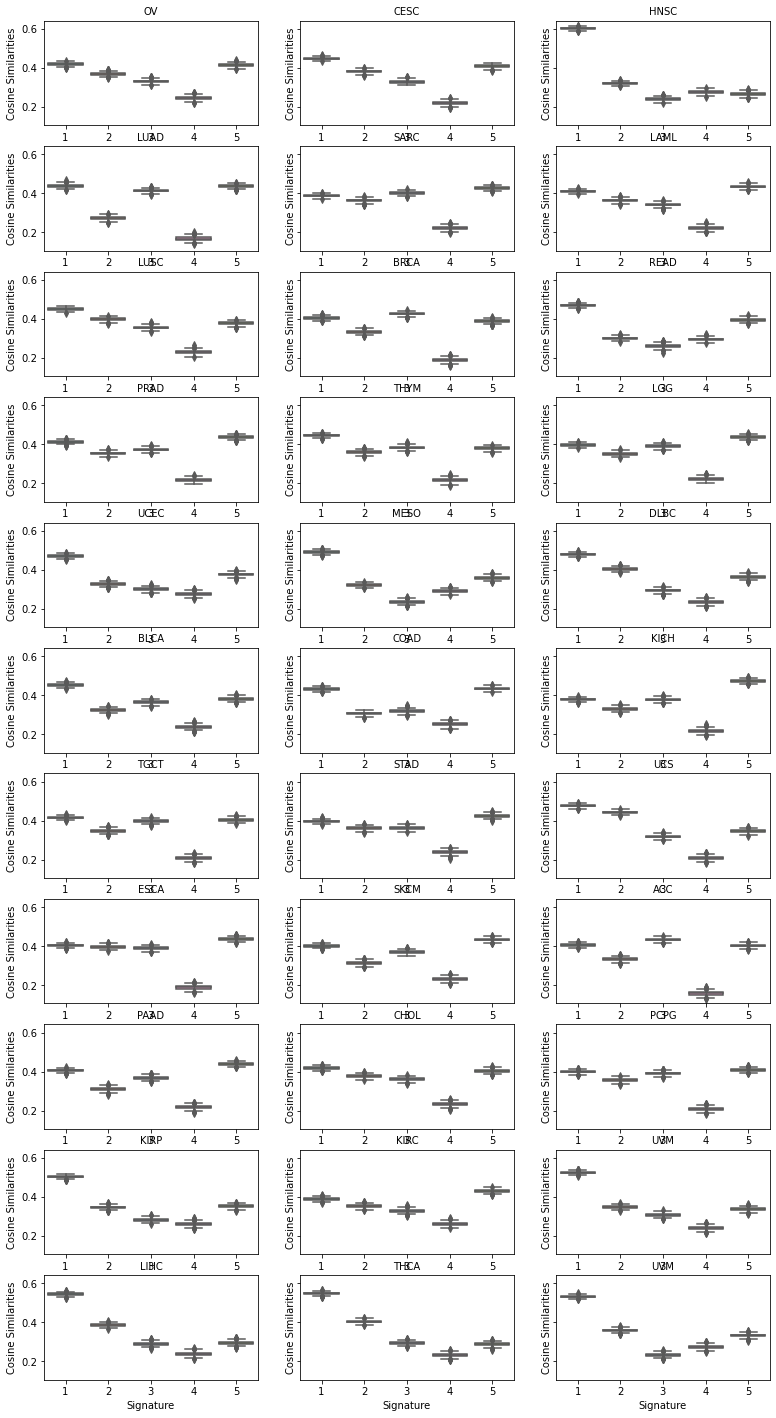

In [22]:
fig, axes = plt.subplots(11, 3, figsize=(13,25), sharey=True)
counter = 0
for col in range(0, 3):
    for row in range(0, 11):
        cosine30_1cancer = cosine30_df[cosine30_df['cancer_type'] == cancertypes[counter]]
        cosine70_1cancer = cosine70_df[cosine70_df['cancer_type'] == cancertypes[counter]]
        if counter < 32:
            counter += 1
        
        cosine_sim = []
        for signature in range(1, 6):
            sig30_df = cosine30_1cancer[str(signature)]
            sig70_df = cosine70_1cancer[str(signature)]
            differences = []
            for i in range(1000):
                sample30 = sig30_df.sample(n = 10000, replace=True)
                sample70 = sig70_df.sample(n = 10000, replace=True)
                dist = 1 - spatial.distance.cosine(sample30, sample70)
                differences.append(dist)
            cosine_sim.append(differences)
        cosine_df = pd.DataFrame(cosine_sim).transpose()
        cosine_df = pd.melt(cosine_df, var_name = 'Signature', value_name = 'Cosine Similarity')
        cosine_df.Signature = cosine_df.Signature + 1

        sns.boxplot(ax=axes[row, col], x = 'Signature', y = 'Cosine Similarity', data=cosine_df, palette='Set2')
        axes[row, col].set_ylabel("Cosine Similarities", fontsize=10)
        # axes[row, col].set_xlabel("Signature", fontsize=10)
        axes[row, col].tick_params(axis='x', labelsize=10)
        axes[row, col].tick_params(axis='y', labelsize=10)
        axes[row, col].set_title(str(cancertypes[counter]), fontsize=10)
plt.savefig("../figures/figure9cosine.pdf")